### sources
- https://stackoverflow.com/questions/56104778/conditional-pip-install-in-google-colab-jupyter-notebook


### installations

```bash
# extract longitude & latitude
pip install pycountry-convert
pip install geopy
```

In [1]:
### installations

# !pip install pycountry-convert
# !pip install geopy

In [2]:
### imports
import os
import numpy as np
import pandas as pd


from pandas.io.json import build_table_schema
import markdown
 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')


%matplotlib inline

In [3]:
## specify current directory

running_in_drive = True
if running_in_drive:
  os.chdir("/content/drive/MyDrive/GA/capstone/code")

# environment variables

DATA_PATH = '../data'
ORIGINAL_DATA_PATH = f'{DATA_PATH}/original/csv_offshore_leaks'
CLEAN_DATA_PATH = f'{DATA_PATH}/clean'
NODE_EDGES_PATH = f'{CLEAN_DATA_PATH}/nodes_edges'
GRAPH_PATH = f'{CLEAN_DATA_PATH}/graphs'


MD_PATH = '../presentation/tables'
IMAGE_PATH = '../presentation/images'
IMAGE_PATH_MAPS = f'{IMAGE_PATH}/maps'
IMAGE_PATH_GRAPHS = f'{IMAGE_PATH}/graphs'
IMAGE_PATH_DEGREES = f'{IMAGE_PATH}/degrees'


In [4]:
%%writefile tools/__init__.py

from .loading import DataH
from .general import General
from .plots import PlotH
from .locations import LocH

Overwriting tools/__init__.py


In [5]:
%%writefile tools/locations.py
### Here is a class for handling fetching locations.



import pycountry_convert as pc
from geopy.geocoders import Nominatim

class LocH():
  def __init__(self):
    pass

  def get_longitude_latitude(self, address):
    """
    Extract longitude and latitude
    """
    geolocator = Nominatim(user_agent="http")
    location = geolocator.geocode(address)
    if location!=None:
      return {
          'latitude':location.latitude,
          'longitude':location.longitude
      }

  def country_to_continent(self, country_name):
    """
    Taken with modification from https://stackoverflow.com/questions/55910004/get-continent-name-from-country-using-pycountry
    example: country_to_continent('British Virgin Islands')
    """
    try:
      if len(country_name.split(';'))>1:
        return ';'.join([country_to_continent(c) for c in country_name.split(';')])
    except Exception as e:
      return country_name

    try:
      country_alpha2 = pc.country_name_to_country_alpha2(country_name)
      country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
      country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
      return country_continent_name
    except Exception as e:
      print(country_name, e)
      return ''

Overwriting tools/locations.py


In [6]:
%%writefile tools/plots.py
### A class for handling the plots.



import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import missingno as msno
import numpy as np

from matplotlib.lines import Line2D



IMAGE_PATH = '../presentation/images'
IMAGE_PATH_MAPS = f'{IMAGE_PATH}/maps'
IMAGE_PATH_GRAPHS = f'{IMAGE_PATH}/graphs'
IMAGE_PATH_DEGREES = f'{IMAGE_PATH}/degrees'
IMAGE_PATH_NULL = f'{IMAGE_PATH}/null'

class PlotH:
  def __init__(self):
    self.title_fontsize = 24
    self.suptitle_fontsize = 26
    self.legend_fontsize=24


  def round_large_num(self, num):
    """
    A helper method to display large numbers.
    """
    if num > 1000:
      r = int(np.log10(num))-1
      return round(num, -r)
    return num

  def color_labels_by_source_target(self,g, s_col='b', t_col='g', lw=2):
    """
    Color the lables by source/target
    """
    labels = g.get_xticklabels()
    custom_lines = [Line2D([0], [0], color=s_col, lw=lw),
                    Line2D([0], [0], color=t_col, lw=lw)]
    legend_text = ['Source', 'Target']
    for label in labels:
      t = label.get_text()
      if t.endswith('_s') or t.startswith('START_'):
        label.set_color(s_col)
      elif t.endswith('_t') or t.startswith('END_'):
        label.set_color(t_col)
    return custom_lines, legend_text

  def get_missing_info(self, df, name, conversions={}):
      """
      Extract the missing information corresponding to the given table.
      """
      null_df = df.copy()
      null_df = null_df.rename(columns = conversions)
      s = null_df.isnull().sum().sum()
      null_ratio = (s/df.size)*100
      null_ratio_str = f'{null_ratio:.0f}%' if null_ratio > 1 else f'{null_ratio:.3f}%'
      # title_str =  f'shape: ({df.shape[0]:,}|{df.shape[1]})\nnull ratio: {null_ratio_str}'
      nrow = self.round_large_num(df.shape[0])
      title_str =  f'shape: ({nrow:,}|{df.shape[1]})\nnull ratio: {null_ratio_str}'
      return null_df, title_str

  def plot_missing_values(self, df, name, conversions={}, figsize = (8, 3), is_clean=True, 
                          bbox_to_anchor=(0, -.05),
                          method='matrix', extra='', to_sort=False, change_colors=False, title=''):
      """
      Method for plotting values of missing values.
      """
      null_df, title_str = self.get_missing_info(df, name, conversions=conversions)

      if to_sort:
        null_df = msno.nullity_sort(null_df, sort='descending')

      if method == 'matrix':
        g = msno.matrix(null_df, figsize=figsize, sparkline=False); 
      else:
        g = msno.dendrogram(null_df, figsize=figsize, orientation='top');

      g.set(yticklabels=[])
      if change_colors:
        custom_lines, legend_text = self.color_labels_by_source_target(g)
        plt.legend(custom_lines, legend_text, 
                  bbox_to_anchor=bbox_to_anchor, ncol=2,
                   loc='upper left', frameon=False, fontsize=self.legend_fontsize)

      name_to_show = name.replace('_', ' ')
      default_title = f'Table: "{name_to_show}"'
      use_title = title if title!='' else default_title
      plt.title(f'{use_title}\n{title_str}', fontsize=self.title_fontsize)
      modname = name.replace(' of', '').replace('/', '_').replace(' ', '_').replace('__', '_')
      fname = f'{IMAGE_PATH_NULL}/{method}_{modname}_{"clean" if is_clean else "orig"}_{extra}.png'
      plt.savefig(fname, bbox_inches='tight', dpi=300)


  def plot_missing_data_orig_clean(self, df_orig, df_clean, name, conversions={}, figsize = (20, 3), method='matrix'):
    """
    Plot missing data for a given method of showing null values
    """
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    null_df_orig, title_str_orig = self.get_missing_info(df_orig, name, conversions=conversions)
    null_df_clean, title_str_clean = self.get_missing_info(df_clean, name, conversions=conversions)


    s_null_df_orig = msno.nullity_sort(null_df_orig, sort='descending')
    if method == 'matrix':
      g0 = msno.matrix(s_null_df_orig, ax=axs[0], sparkline=False); 
    else:
      g0 = msno.dendrogram(s_null_df_orig, orientation='top', ax=axs[0]); 

    g0.set(yticklabels=[])
    g0.set_title(title_str_orig)

    s_null_df_clean = msno.nullity_sort(null_df_clean, sort='descending')

    if method == 'matrix':
      g1 = msno.matrix(s_null_df_clean, ax=axs[1], sparkline=False); 
    else:
      g1 = msno.dendrogram(s_null_df_clean, orientation='top', ax=axs[1]); 
    g1.set(yticklabels=[])
    g1.set_title(title_str_clean)


    name_to_show = name.replace('_', '\n')
    plt.suptitle(f'{name_to_show}', fontsize=self.suptitle_fontsize)
    fname = f'{IMAGE_PATH_NULL}/missing_{method}_{name}_orig_clean.png'
    plt.savefig(fname, bbox_inches='tight', dpi=300)


  def plot_edge_types_bar_chart(self, edges_info, figsize=(10, 15), count=25):
    """
    Make a bar chart for displaying the count of links.
    """
    links = edges_info['link'].value_counts().index.tolist()
    total = len(links)
    title = f'Edge Types\n{count} of {total}'
    plt.figure(figsize=figsize)
    g = sns.countplot(data=edges_info, y='link',alpha=.5,
                order = edges_info['link'].value_counts().head(count).index);
    g.set_title('Edge Types')
    g.set_ylabel('')
    g.set_xscale('log')
    g.tick_params(left=False)
    sns.despine()
    fname = f'{IMAGE_PATH}/edges/edge_types_bar_chart_{count}_{total}.png'
    plt.savefig(fname, bbox_inches='tight', dpi=300)

  def plot_categorical_heatmap(self, dataframe, ncat=50, cols_to_remove=[], cmap='tab20c',
                               sort_by=[], figsize=(25, 10), title='', return_df=False):
    """
    A method for showing the categorical data in a similar look to missingno.
    Got help from 
    https://stackoverflow.com/questions/61097853/seaborn-heatmap-adjust-linewidth-for-vertical-and-horizontal-line-separately
    for adjusting the heatmap.
    """

    sort_by_str = ''
    if sort_by:
      sort_by_str = 'sort_'+ '_'.join(sort_by)
    columns_to_pick = dataframe.columns
    if ncat!=0:
      columns_to_pick = dataframe.nunique()[dataframe.nunique()<ncat].index.tolist()

    cols = [c for c in columns_to_pick if c not in cols_to_remove]
    df = dataframe[cols].copy()#.sample(100)
    mask = np.zeros_like(df)
    df_is_null = df.isnull()
    mask[df_is_null] = True
    nrows = f'e{int(np.log10(df.shape[0]))}'
    df = df.astype(str)
    hmdf = df.stack(dropna=False).rank(method='dense').unstack(fill_value=np.nan)
    hmdf = hmdf.mask(df_is_null)

    if not sort_by:
      sort_by = hmdf.nunique().sort_values().index.tolist()
    hmdf.sort_values(by=sort_by, inplace=True)

    plt.figure(figsize=figsize)

    hmdf = (hmdf-hmdf.mean())/(hmdf.max()-hmdf.min())


    with sns.axes_style("white"):
      g = sns.heatmap(hmdf, cbar=False,mask=mask, cmap=cmap, yticklabels=False)
      g.xaxis.set_ticks_position("top")
      g.set_xticklabels(g.get_xticklabels(),rotation = 70);
      g.set_xlabel('');
      # g.set_yticklabels([])
      g.tick_params(left=False, top=False)
      title_str = title.title()+' Columns'
      g.set_title(title_str, fontsize=self.title_fontsize)


      for i in range(hmdf.shape[1]+1):
        g.axvline(i, color='white', lw=2)
      fpath = f'{IMAGE_PATH}/edges/heatmap_{title}_{sort_by_str}_n{ncat}_r{nrows}_c{cmap}.png'
      plt.savefig(fpath, bbox_inches='tight', dpi=300)
    if return_df:
      return hmdf


Overwriting tools/plots.py


In [7]:
%%writefile tools/general.py


class General:
  def __init__(self):
    pass


Overwriting tools/general.py


In [8]:
%%writefile tools/loading.py

### A class for handling loading and writing the data.


import os
import pandas as pd

DATA_PATH = '../data'
ORIGINAL_DATA_PATH = f'{DATA_PATH}/original/csv_offshore_leaks'
CLEAN_DATA_PATH = f'{DATA_PATH}/clean'


class DataH:
  def __init__(self):
    pass

  def read_dataframes(self, paths):
    data_frames = {}
    for name, path in paths.items():
      data_frames[name] = pd.read_csv(path)
    return data_frames

  def get_original_file_paths(self, ext='.csv'):
    file_names = os.listdir(ORIGINAL_DATA_PATH)
    return {f"{'_'.join(n.split('.')[1:-1])}": f'{ORIGINAL_DATA_PATH}/{n}' 
            for n in file_names
            if n.endswith(ext)} 

  def get_clean_file_paths(self, ext='.csv'):
    file_names = os.listdir(CLEAN_DATA_PATH)
    return {f"{n.split('.')[0]}": f'{CLEAN_DATA_PATH}/{n}' 
            for n in file_names if n.endswith(ext)} 


  def read_original_dataframes(self):
    paths = self.get_original_file_paths()
    return self.read_dataframes(paths)

  def read_clean_dataframes(self):
    paths = self.get_clean_file_paths()
    return self.read_dataframes(paths)


  def get_common_between_lists(self, lists):
    common = set(lists[0])
    for l in lists[1:]:
      common = common.intersection(l)
    return list(common)


  def print_unique_items(self, df):
    to_drop = []
    nunique = df.nunique().to_dict()
    for k, v in nunique.items():
      if v<=1:
        to_drop.append(k)
      if v == 1:
        print(f'\n\tThere is {v} value for "{k}":\n\t\t{df.head(1)[k].values[0]}')
      elif v < 5:
        print(f'\n\tThere are {v} values for "{k}"')
        for value in df[k].unique().tolist():
          print(f'\t\t{value}')
    if len(to_drop)>0:
      print('\n\tdrop ', to_drop)
    return to_drop


  def write_clean_data_frames(self):

    given_to_drop = {'edges': ['TYPE'], 'nodes_entity': ['note']}
    data_frames = self.read_original_dataframes()
    to_drop_dict = {}
    for name, df in data_frames.items():
      print(f'\n\n{name}:')
      to_drop = self.print_unique_items(df)
      to_drop_dict.update({name: to_drop})


    common_to_drop_columns = self.get_common_between_lists(list(to_drop_dict.values()))


    clean_data_frames = {}
    for name, df in data_frames.items():
      df_new = df.copy().drop(columns=to_drop_dict[name]+given_to_drop.get(name, []))
      df_new.drop_duplicates(inplace = True)
      if 'node_id' in df_new.columns:
        if df_new['node_id'].isnull().sum()>0:
          display(df_new['node_id'].isnull().sum())
      clean_data_frames.update({name: df_new})

    for name, df in clean_data_frames.items():
      print(f'\n\n{name}:')
      self.print_unique_items(df)

      if 'jurisdiction' in df.columns:
        null_j = df['jurisdiction_description'] == 'Undetermined'
        df.loc[null_j , 'jurisdiction'] = None
        df.loc[null_j , 'jurisdiction_description'] = None
        df.loc[df['jurisdiction_description']=='Recorded in leaked files as "fund"', 'jurisdiction_description'] = 'Recorded as fund'

      if 'country_codes' in df.columns:
        no_location_rows = df['country_codes']=='XXX'
        df.loc[no_location_rows, 'country_codes'] = None
        df.loc[no_location_rows, 'countries'] = None
      if name == 'edges':
        df['start_date'] = pd.to_datetime(df['start_date'])
        df['end_date'] = pd.to_datetime(df['end_date'])

      if 'incorporation_date' in df.columns:
        df['incorporation_date'] = pd.to_datetime(df['incorporation_date'])
      df.to_csv(f'{CLEAN_DATA_PATH}/{name}.csv', index=False)


Overwriting tools/loading.py


In [14]:
from tools import *


### The following methods use the functions defined in the handlers.


def plot_missing_orig_clean(method = 'dendrogram'):
  """
  Plot the missing data.
  """
  data_frames_orig = DataH().read_original_dataframes()
  data_frames_clean = DataH().read_clean_dataframes()

  for name, df_orig in data_frames_orig.items():
    df_clean = data_frames_clean[name]
    PlotH().plot_missing_data_orig_clean(df_orig, df_clean, name, method=method)


def plot_edges_nodes_original_combined_missing():
  """
  Plot the missing value in edges and nodes
  """
  edges_all = pd.read_csv(f'{NODE_EDGES_PATH}/edges_just_combined_with_nodes.csv')

  e_cols = [c for c in edges_all.columns if c in edges.columns]
  n_cols = [c for c in edges_all.columns if c not in edges.columns]
  cols = e_cols + sorted(n_cols)
  cols = [c for c in cols if c not in ['table_s', 'table_t']]

  PlotH().plot_missing_values(edges_all[cols], 'edges and nodes', is_clean=True, title='Edges & Nodes',
                              to_sort=False, 
                                extra='combined_with_nodes', figsize=(25, 10), change_colors=True)

def plot_all_missing_graphs():
  """
  Plot all the missing graphs.
  """
  plot_missing_orig_clean(method='matrix')
  plot_missing_orig_clean(method='dendrogram')
  data_frames_clean = DataH().read_clean_dataframes()

  nodes = combine_nodes(data_frames_clean)
  edges = data_frames_clean['edges']

  cols = sorted([c for c in nodes.columns if c not in ['table']])
  PlotH().plot_missing_values(nodes[cols], 'nodes', is_clean=True, extra='just_combined_all', figsize=(12, 5))

  PlotH().plot_missing_values(edges, 'edges', is_clean=True, extra='all', figsize=(5, 10))

  edges_all = (edges
              .merge(nodes, left_on='START_ID', right_on='node_id')
              .merge(nodes, left_on='END_ID', right_on='node_id', suffixes=('_s', '_t'))
              .drop_duplicates(subset=edges.columns)
              .drop(columns=['node_id_s', 'node_id_t'])
    )
  edges_all.to_csv(f'{NODE_EDGES_PATH}/edges_just_combined_with_nodes.csv', index=False)
  plot_edges_nodes_original_combined_missing()
 

def combine_nodes(data_frames_clean):
  """
  Combine the nodes from the given tables.
  """
  #data_frames_clean = DataH().read_clean_dataframes()
  frames = []
  node_frames = {name.replace('nodes_', ''): df for name, df in data_frames_clean.items() if name.startswith('nodes')}
  
  for table, df in node_frames.items():
    node_df = df.copy()
    node_df['table'] = table
    frames.append(node_df)
  nodes = pd.concat(frames)

  rep = {
      'incorporated': 'inc',
      'corporation': 'corp',
      'limited': 'ltd',
      'corp.': 'corp',
      'ltd.': 'ltd',
      'inc.': 'inc',
      'the bearer':'bearer',
      '?': '',
  }

  nodes['name'] = nodes['name'].str.lower().str.strip().str.lstrip('\t')
  for k, v in rep.items():
    nodes['name'] = nodes['name'].str.replace(k, v)
  nodes['name'] = (nodes['name'].str.strip().replace('', np.nan).str.title())
  nodes = nodes.replace(r'^\s*$', np.NaN, regex=True)
  nodes.to_csv(f'{NODE_EDGES_PATH}/nodes_just_combined.csv', index=False)

  return nodes


def write_country_lat_long_df():
  """
  Make a table including the latitude and longitude information for the countries.
  """
  nodes = combine_nodes(data_frames_clean)
  new_nodes = add_info_to_nodes(nodes)
  countries = new_nodes['country'].unique()
  country_to_long_lat = {country: LocH().get_longitude_latitude(country) for country in countries}
  country_lat_long = pd.DataFrame(country_to_long_lat).T.iloc[1:]
  country_lat_long.index.name='country'
  country_lat_long.reset_index(inplace=True)
  country_lat_long.to_csv(f'{CLEAN_DATA_PATH}/country_lat_long.csv', index=False)

def add_info_to_nodes(nodes):
  """
  Add continents to the nodes and make column name changes.
  """
  new_nodes = nodes.copy()
  new_nodes.dropna(subset=['country_codes'], inplace=True)
  new_nodes['country_count'] = new_nodes['country_codes'].str.split(';').str.len().astype(int)
  codes = new_nodes.loc[new_nodes['country_count']==1, 'country_codes'].unique().tolist()
  codes_to_continent_dict = {code: LocH().country_to_continent(code) for code in codes}
  new_nodes['continent'] = new_nodes['country_codes'].map(codes_to_continent_dict)
  new_nodes = new_nodes[new_nodes['country_count']==1]
  new_nodes.rename(columns={'countries': 'country', 'country_codes': 'country code'}, inplace=True)
  return new_nodes

def add_general_lat_long_to_nodes(new_nodes):
  """
  Add general latitude and longitude information to the nodes.
  """
  country_lat_long = pd.read_csv(f'{CLEAN_DATA_PATH}/country_lat_long.csv')
  new_nodes = new_nodes.merge(country_lat_long, on='country', how='left')
  return new_nodes

def add_lat_long_to_nodes(new_nodes):
  """
  Add the already extracted longitude and latitude to the nodes.
  """
  nodes_lat_lon =pd.read_csv(f'{NODE_EDGES_PATH}/nodes_lat_lon.csv')
  new_nodes = new_nodes.merge(nodes_lat_lon, on='node_id', how='left')
  return new_nodes

def construct_single_country_nodes(data_frames_clean):
  """
  Load nodes, add location information and save it.
  """
  nodes = combine_nodes(data_frames_clean)
  new_nodes = add_info_to_nodes(nodes.copy())
  new_nodes = add_lat_long_to_nodes(new_nodes.copy())
  new_nodes.to_csv(f'{NODE_EDGES_PATH}/nodes_single_country.csv', index=False)


def write_default_edges():
  """
  Write the clean default edges.
  """
  data_frames_clean = DataH().read_clean_dataframes()
  edges = data_frames_clean['edges']
  edges.drop_duplicates().to_csv(f'{NODE_EDGES_PATH}/default_edges.csv', index=False)


def create_edges_combined_nodes_single_country():
  """
  Combine the node information with the edges and write them to file.
  """
  edges = pd.read_csv(f'{NODE_EDGES_PATH}/default_edges.csv')
  base_columns = edges.columns
  nodes = pd.read_csv(f'{NODE_EDGES_PATH}/nodes_single_country.csv')
  edges_all = (edges
              .merge(nodes, left_on='START_ID', right_on='node_id')
              .merge(nodes, left_on='END_ID', right_on='node_id', suffixes=('_s', '_t'))
              .drop_duplicates(subset=edges.columns)
              .drop(columns=['node_id_s', 'node_id_t']))

  edges_all = edges_all[(edges_all['country_count_t']==1) & (edges_all['country_count_s']==1)]
  e_cols = [c for c in edges_all.columns if c in edges.columns]
  n_cols = [c for c in edges_all.columns if c not in edges.columns]
  cols = e_cols + sorted(n_cols)
  edges_all = edges_all[cols]
  edges_all.to_csv(f'{NODE_EDGES_PATH}/edges_all_single_country.csv', index=False)
  edges_single = edges_all[base_columns]
  edges_single.to_csv(f'{NODE_EDGES_PATH}/edges_single_country.csv', index=False)


def add_location_to_nodes_without_address():
  """
  Add location to the nodes that do not have address but have country information
  """
  nodes = pd.read_csv(f'{NODE_EDGES_PATH}/nodes_single_country.csv')
  remaining_countries = nodes.loc[(nodes['lat'].isnull()) & (nodes['address'].isnull()), 'country'].unique().tolist()
  for country in remaining_countries:
    print(country)
    out = LocH().get_longitude_latitude(country)
    print(out)

    cond = (nodes['lat'].isnull()) & (nodes['address'].isnull()) & (nodes['country']==country)
    nodes.loc[cond, 'lat'] = out['latitude']
    nodes.loc[cond, 'lon'] = out['longitude']

    nodes.drop_duplicates().to_csv(f'{NODE_EDGES_PATH}/nodes_single_country.csv', index=False)

    lat_lon = nodes[['node_id','lat', 'lon']]
    lat_lon.dropna().drop_duplicates().to_csv(f'{NODE_EDGES_PATH}/nodes_lat_lon.csv', index=False)


def add_location_to_remining_nodes():
  """
  Add location the the nodes that are missing location.
  """
  nodes = pd.read_csv(f'{NODE_EDGES_PATH}/nodes_single_country.csv')
  remaining_countries = nodes.loc[(nodes['lat'].isnull()) & ~(nodes['address'].isnull()), 'country'].unique().tolist()
  for country in remaining_countries:
    print(country)
    out = LocH().get_longitude_latitude(country)
    print(out)

    cond = (nodes['lat'].isnull()) & ~(nodes['address'].isnull()) & (nodes['country']==country)
    print(sum(cond))
    nodes.loc[cond, 'lat'] = out['latitude']
    nodes.loc[cond, 'lon'] = out['longitude']

    nodes.drop_duplicates().to_csv(f'{NODE_EDGES_PATH}/nodes_single_country.csv', index=False)

    lat_lon = nodes[['node_id','lat', 'lon']]
    lat_lon.dropna().drop_duplicates().to_csv(f'{NODE_EDGES_PATH}/nodes_lat_lon.csv', index=False)


def plot_edges_info(edges_info, filter={}, figsize=(25, 10), bbox_to_anchor = (0, -.05)):
    """
    Plot missing information for edges filtered.
    """
    e = edges_info.copy()
    s0 = e.shape[0]
    width, height = figsize
    b0, b1 = bbox_to_anchor
  
    extra = 'edge_info_single'
    title =''
    if filter:
      title_arr = []
      fextra =''
      for k, v in filter.items():
        e = e[e[k]==v]
        title_arr.append(f" {k}: '{v}'")
        fextra+=f"_{k}_{v.replace(' ', '_').replace('/', '_')}"

      title = ' - '.join(title_arr)
      extra += fextra
      s1 = e.shape[0]
      ratio = int(np.log(s1))/int(np.log(s0))
      figsize = (width, max(ratio * height,1))
    cols = [c for c in e.columns if c not in ['table_s', 'table_t', 
                                              'jurisdiction_description_s',
                                              'country_count_s', 'country_count_t',
                                              'jurisdiction_description_t']]
    PlotH().plot_missing_values(e[cols], 'edge information', is_clean=True, title=title,
                              to_sort=False,bbox_to_anchor = bbox_to_anchor,
                              extra=extra, figsize=figsize, change_colors=True)
    

def plot_heatmaps_for_nodes_edges(nodes, edges, edges_info):
  """
  Plot categorical (clustered) heatmaps.
  """

  cols_to_remove = ['START_ID', 'END_ID', 'table_s', 'table_t',
                      'address_s', 'address_t','jurisdiction_description_t',
                        'jurisdiction_description_s','country_count_s', 'country_count_t']

  hm = PlotH().plot_categorical_heatmap(edges_info, ncat=0, cols_to_remove=cols_to_remove, 
                                    return_df=True,
                                    title ='Edges',
                                    sort_by=['link'])
  cols_to_remove = ['jurisdiction_description', 'node_id', 'country_count', 'table']
  hm = PlotH().plot_categorical_heatmap(nodes, ncat=0, cols_to_remove=cols_to_remove, 
                                    return_df=True,
                                    title ='Nodes',
                                    sort_by=['country'], figsize=(12, 5))

  hm = PlotH().plot_categorical_heatmap(edges, ncat=0, cols_to_remove=[], 
                                    return_df=True,
                                    title ='Edges Table',
                                    sort_by=['START_ID', 'END_ID', 'link'], figsize=(5, 10))
  hm = PlotH().plot_categorical_heatmap(edges, ncat=0, cols_to_remove=[], 
                                    return_df=True,
                                    title ='Edges Table',
                                    sort_by=[], figsize=(5, 10))

In [10]:
### code to clean the data, save it and prepare nodes/edges


# DataH().write_clean_data_frames()

# plot_all_missing_graphs()
# PlotH().plot_missing_values(edges, 'edges', is_clean=True, extra='single_country_simple', figsize=(5, 10))

# data_frames_clean = DataH().read_clean_dataframes()
# construct_single_country_nodes(data_frames_clean)
# write_default_edges()
# create_edges_combined_nodes_single_country()

In [11]:
edges = pd.read_csv(f'{NODE_EDGES_PATH}/edges_single_country.csv')
nodes = pd.read_csv(f'{NODE_EDGES_PATH}/nodes_single_country.csv')
edges_info = pd.read_csv(f'{NODE_EDGES_PATH}/edges_all_single_country.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,5,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4,7,8,17,18,19,20,21,22,23,24,30,31,32,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
plot_edges_info(edges_info, filter={})
links = edges_info['link'].value_counts().index.tolist()
for link in links:
  plot_edges_info(edges_info, filter={'link': link})

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3,4,10,11,12,13,14,15,16,21,22,23,24,25,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


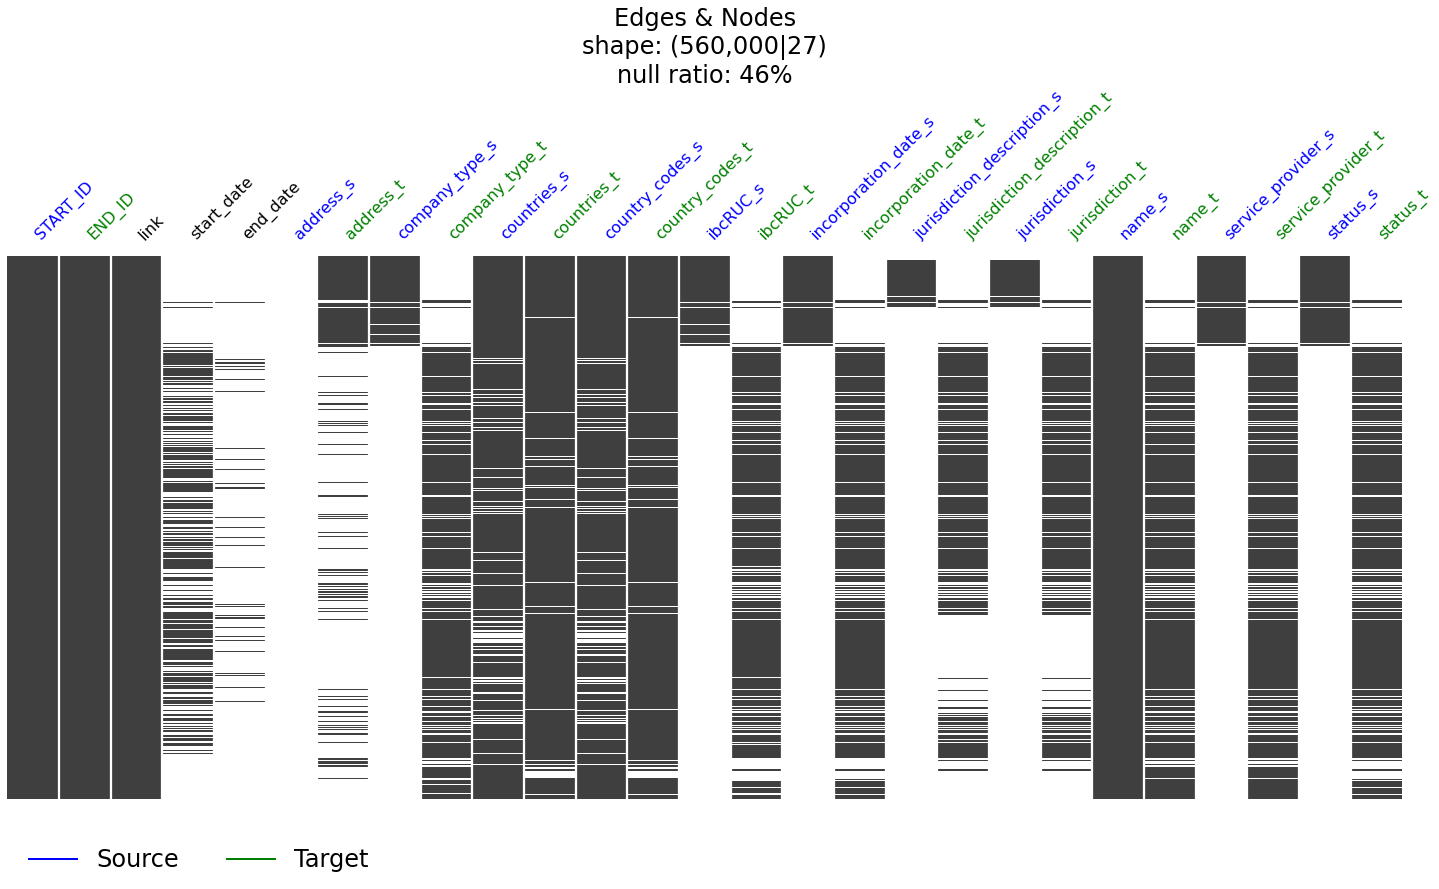

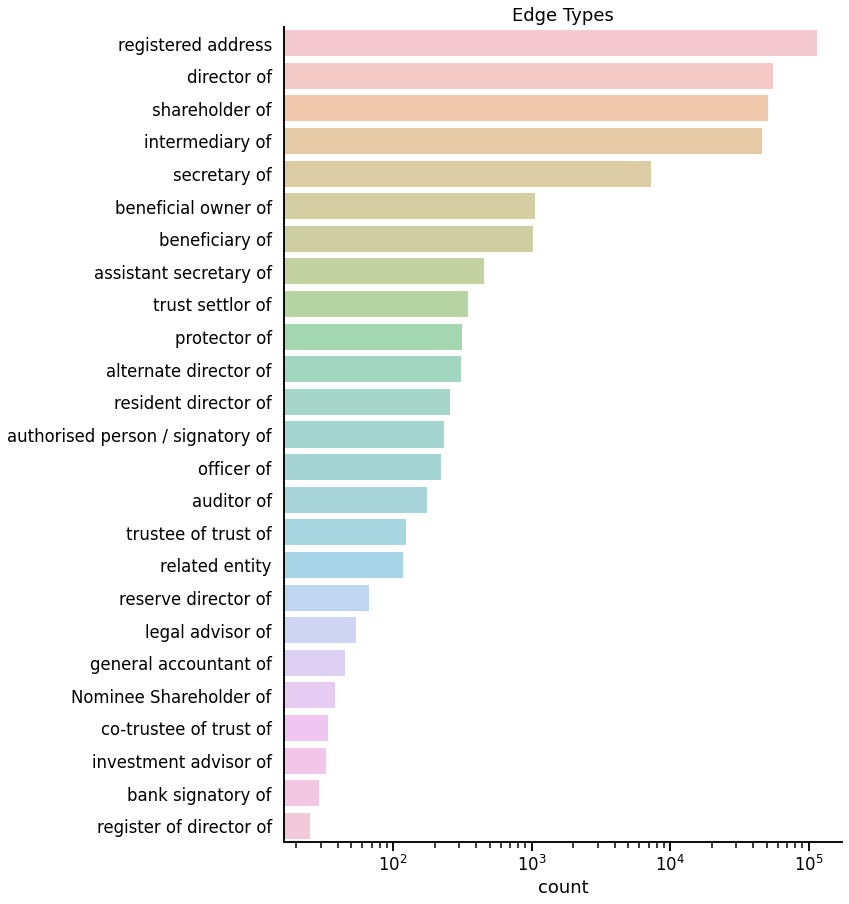

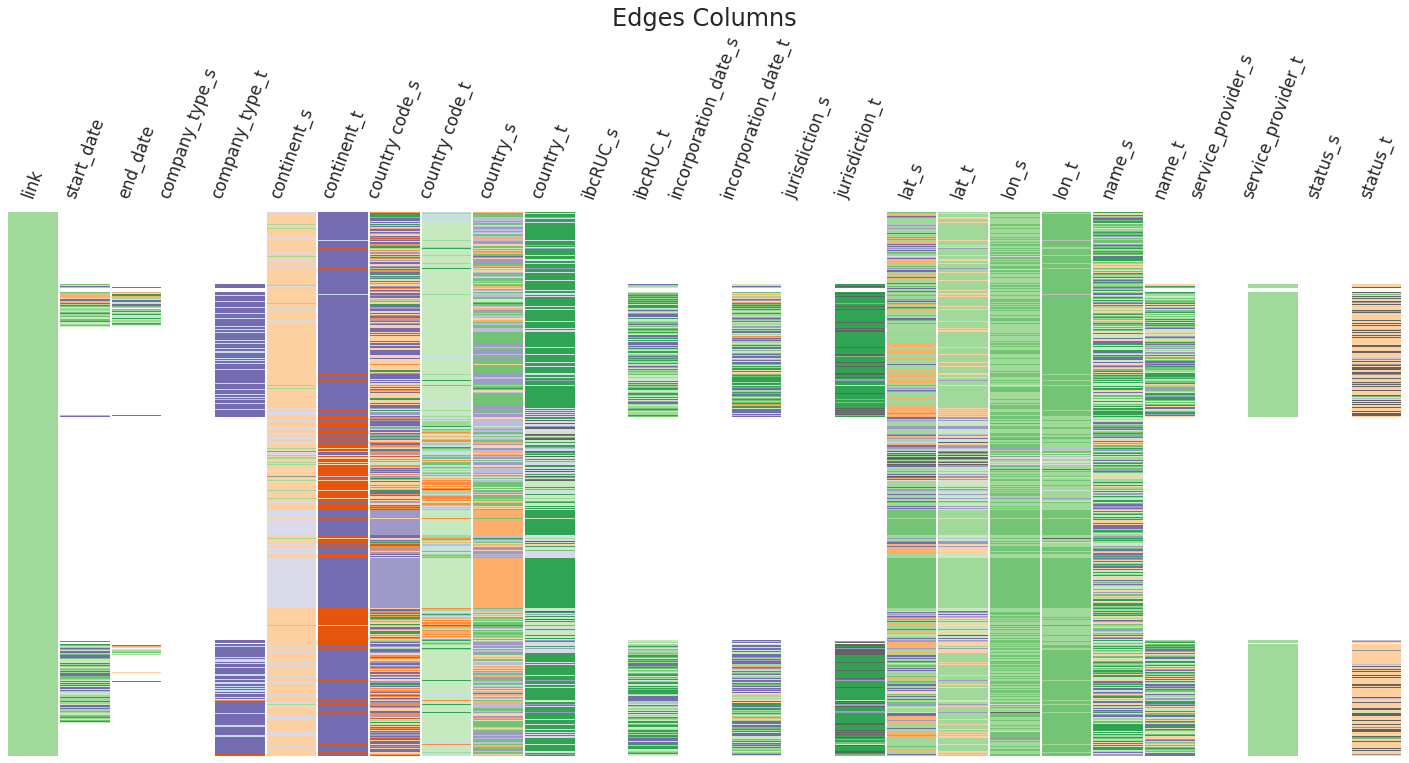

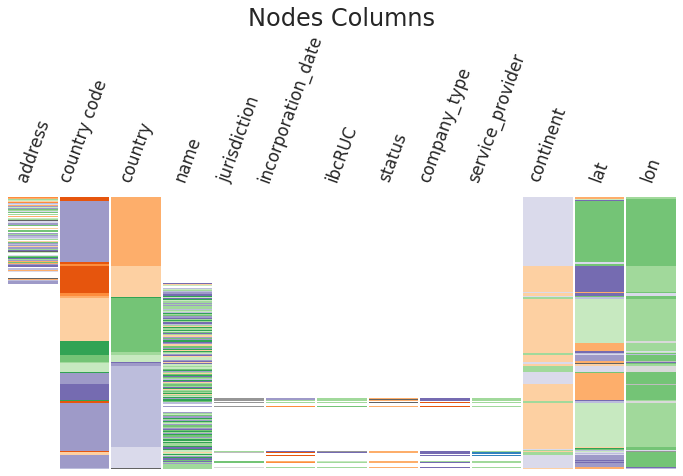

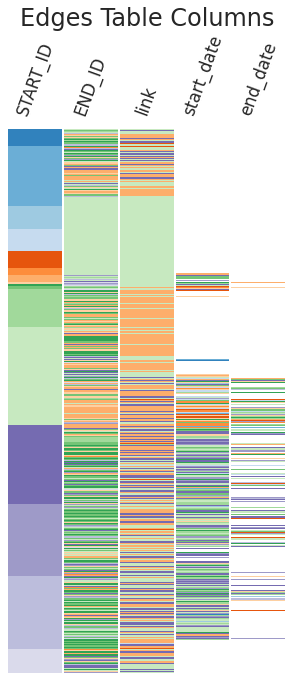

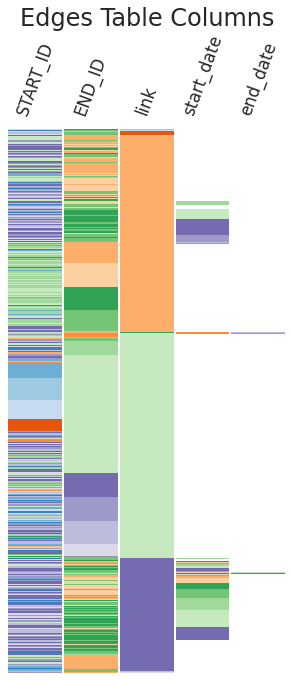

In [13]:
plot_edges_nodes_original_combined_missing()

PlotH().plot_edge_types_bar_chart(edges_info, figsize=(10, 15), count=25)
plot_heatmaps_for_nodes_edges(nodes, edges, edges_info)